In [1]:
from radiosim.modems import BPSKModem, QPSKModem
import numpy as np
import matplotlib.pyplot as plt
import struct
from itertools import product
import threading
import zmq

In [2]:
def matched_filter(bbsig, taps):
    return np.convolve(bbsig, taps, 'same')


def get_closest_symbols(modem, rx_symbols):
    symbolset = np.array(list(modem.constellation.demapper.keys()))
    closest_symbols = [symbolset[np.argmin(abs(sym - symbolset))] for sym in rx_symbols]
    return closest_symbols


def make_bytewise_demapper(mapper):
    bps = int(np.log2(len(mapper)))
    symbols = mapper.values()
    _8bword_demapper = {sym:word for word,sym in mapper.items()}
    # Cartesian product SxSx...xS of symbol set S such that each element maps to 1 byte
    byte_length_seqs = product(symbols, repeat=8//bps) 
    demapper = {}
    for sym_seq in byte_length_seqs:
        # for symbol sequence, get sequence of uint8 words (only last bps bits are meaningful)
        _8bword_seq = bytearray([_8bword_demapper[sym] for sym in sym_seq])
        # get only the relevant LSB of each uint8 word and group into byte-length sequences
        _8bword_seq_bits = np.unpackbits(_8bword_seq)
        byte_bits = [_8bword_seq_bits[i:i+8][-bps:] for i in range(0,len(_8bword_seq_bits), 8)]
        byte_bits = np.array(byte_bits).flatten()
        # pack byte-length sequences into meaningful uint8 words
        demapper[sym_seq] = np.packbits(byte_bits)[0].tobytes()
    return demapper

## QPSK Data Transmission with Matched Filter

In [3]:
modem = QPSKModem()
npoints = 10
maxval = 100
data = (np.random.rand(npoints)*maxval).astype(np.uint8)
#data = np.arange(512*2-1)
#npoints = len(data)

if isinstance(data[0], np.float64):
    dtype_format_char = "d"
elif isinstance(data[0], np.uint8):
    dtype_format_char = "B"
elif isinstance(data[0], np.int64):
    dtype_format_char = "q"

sps = 8
noiselvl = 1.0

symbols = modem.map(data)
rrc = modem.get_pulse_filter(sps=sps, num_positive_lobes=4, alpha=0.5)
bb = modem.apply_pulse_filter(symbols, rrc)
nreal = 2*np.random.rand(len(bb)) - 1
nimag = 2*np.random.rand(len(bb)) - 1
bb += noiselvl*(nreal + 1j*nimag)

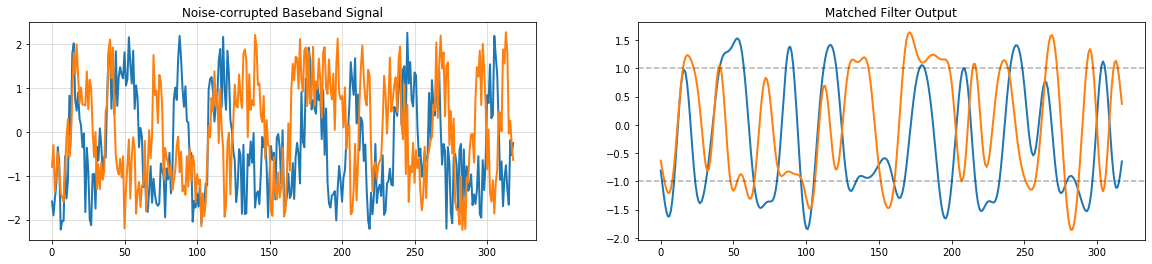

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,4))
ax1.plot(bb[1:].real, lw=2);
ax1.plot(bb[1:].imag, lw=2)
ax1.grid(alpha=0.5)
ax1.set_title("Noise-corrupted Baseband Signal");

rxbb = matched_filter(bb, rrc/np.linalg.norm(rrc)**2)
rx = rxbb[2:]

ax2.plot(rx.real, lw=2)
ax2.plot(rx.imag, lw=2)
ax2.axhline(1.0, color='k', ls='--', alpha=0.3)
ax2.axhline(-1.0, color='k', ls='--', alpha=0.3);
ax2.set_title("Matched Filter Output");

In [5]:
rx_symbols = rx[::sps]
closest_symbols = get_closest_symbols(modem, rx_symbols)

bytewise_demapper = make_bytewise_demapper(modem.constellation.mapper)

spb = 8//modem.constellation.bits_per_symbol # symbols per byte
byte_symbol_seqs = [tuple(closest_symbols[i:i+spb]) for i in range(0,len(rx_symbols), spb)]

rx_bytes = [bytewise_demapper[seq] for seq in byte_symbol_seqs]
rx_rawdata = b''
for byt in rx_bytes: rx_rawdata += byt
rx_data = struct.unpack(dtype_format_char*npoints, rx_rawdata)

res = (data == rx_data)
#print(res)
print(f"Error: {100*(1-sum(res)/len(res))}%")

Error: 0.0%
